In [1]:
# Import modules for our task

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# Import system libraries and our Scripts

import os
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from user_overview_script import UserOverviewScript
from df_cleaning import DataFrameCleaning
from df_info import DataFrameInfo
from df_outlier import *
from plots import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
# Read cleaned Telecom dataset

cleaned_df = pd.read_csv('../data/cleaned_Telecom_data.csv')
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      148506 non-null  int64  
 1   Unnamed:_0                      148506 non-null  int64  
 2   Bearer_Id                       148506 non-null  float64
 3   Start                           148506 non-null  object 
 4   Start_ms                        148506 non-null  float64
 5   End                             148506 non-null  object 
 6   End_ms                          148506 non-null  float64
 7   Dur._(ms)                       148506 non-null  float64
 8   IMSI                            148506 non-null  float64
 9   MSISDN_Number                   148506 non-null  float64
 10  IMEI                            148506 non-null  float64
 11  Last_Location_Name              148506 non-null  object 
 12  Avg_RTT_DL_(ms) 

### **Task 3** - User Experience Analytics
**Task 3.1.** - Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variable

In [33]:
user_experience_df = cleaned_df[[
    "MSISDN_Number",
    "Avg_RTT_DL_(ms)",
    "Avg_RTT_UL_(ms)",
    "Avg_Bearer_TP_DL_(kbps)",
    "Avg_Bearer_TP_UL_(kbps)",
    "Handset_Type"]].copy()

In [34]:
# Instantiate UserOverViewScript class in user_overview_script 

user_overview_script = UserOverviewScript(user_experience_df)

In [35]:
# Convert Average RTT millisecond values to sec

user_experience_df['Avg_RTT_DL_(ms)'] = user_overview_script.convert_ms_to_sec(\
    user_experience_df['Avg_RTT_DL_(ms)'])

user_experience_df['Avg_RTT_UL_(ms)'] = user_overview_script.convert_ms_to_sec(\
    user_experience_df['Avg_RTT_UL_(ms)'])

In [36]:
user_experience_df.rename(columns = {\
    'Avg_RTT_DL_(ms)':'Avg_RTT_DL_(sec)',\
    'Avg_RTT_UL_(ms)':'Avg_RTT_UL_(sec)'\
    }, inplace=True)

In [37]:
# Bring back the deleted TCP Retransmission volume column during data cleaning from the original data 

df = pd.read_csv('../data/Week1_challenge_data_source(CSV).csv')
user_experience_df['TCP_DL_Retrans_Vol_(Bytes)'] = df['TCP DL Retrans. Vol (Bytes)']
user_experience_df['TCP_UL_Retrans_Vol_(Bytes)'] = df['TCP UL Retrans. Vol (Bytes)']

##### Check for Null Values

In [38]:
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   MSISDN_Number               148506 non-null  float64
 1   Avg_RTT_DL_(sec)            148506 non-null  float64
 2   Avg_RTT_UL_(sec)            148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)     148506 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)     148506 non-null  float64
 5   Handset_Type                148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(Bytes)  61271 non-null   float64
 7   TCP_UL_Retrans_Vol_(Bytes)  52879 non-null   float64
dtypes: float64(7), object(1)
memory usage: 9.1+ MB


##### Treat Null Values

In [39]:
# Handle null values of TCP Retransmission volume columns with mean and median based on Skewness value 

user_experience_df = DataFrameCleaning(user_experience_df)
columns = ['TCP_DL_Retrans_Vol_(Bytes)', 'TCP_UL_Retrans_Vol_(Bytes)']
user_experience_df.fill_numerical_column(columns)

Automation in Action...!!!


In [40]:
# Count null values if any

user_experience_df = DataFrameInfo(user_experience_df.df)
user_experience_df.get_null_counts()

MSISDN_Number                 0
Avg_RTT_DL_(sec)              0
Avg_RTT_UL_(sec)              0
Avg_Bearer_TP_DL_(kbps)       0
Avg_Bearer_TP_UL_(kbps)       0
Handset_Type                  0
TCP_DL_Retrans_Vol_(Bytes)    0
TCP_UL_Retrans_Vol_(Bytes)    0
dtype: int64


In [41]:
# Convert dataframe object to dataframe

user_experience_df = user_experience_df.df

In [42]:
user_experience_df['Total_Avg_RTT'] = user_experience_df['Avg_RTT_DL_(sec)'] + \
                                      user_experience_df['Avg_RTT_UL_(sec)']

user_experience_df['Total_Avg_Bearer_TP'] = user_experience_df['Avg_Bearer_TP_DL_(kbps)'] + \
                                      user_experience_df['Avg_Bearer_TP_UL_(kbps)']

user_experience_df['Total_Avg_TCP'] = user_experience_df['TCP_DL_Retrans_Vol_(Bytes)'] + \
                                      user_experience_df['TCP_DL_Retrans_Vol_(Bytes)']
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148506 entries, 0 to 148505
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   MSISDN_Number               148506 non-null  float64
 1   Avg_RTT_DL_(sec)            148506 non-null  float64
 2   Avg_RTT_UL_(sec)            148506 non-null  float64
 3   Avg_Bearer_TP_DL_(kbps)     148506 non-null  float64
 4   Avg_Bearer_TP_UL_(kbps)     148506 non-null  float64
 5   Handset_Type                148506 non-null  object 
 6   TCP_DL_Retrans_Vol_(Bytes)  148506 non-null  float64
 7   TCP_UL_Retrans_Vol_(Bytes)  148506 non-null  float64
 8   Total_Avg_RTT               148506 non-null  float64
 9   Total_Avg_Bearer_TP         148506 non-null  float64
 10  Total_Avg_TCP               148506 non-null  float64
dtypes: float64(10), object(1)
memory usage: 12.5+ MB


In [43]:
user_experience_agg = user_experience_df.groupby('MSISDN_Number').agg({
    'Total_Avg_RTT': 'sum',
    'Total_Avg_Bearer_TP': 'sum',
    'Total_Avg_TCP': 'sum',
    'Handset_Type': [lambda x: x.mode()[0]]})

user_experience = pd.DataFrame(columns=[
    "Total_Avg_RTT",
    "Total_Avg_Bearer_TP",
    "Total_Avg_TCP",
    "Handset_Type"])

user_experience["Total_Avg_RTT"] = user_experience_agg["Total_Avg_RTT"]['sum']
user_experience["Total_Avg_Bearer_TP"] = user_experience_agg["Total_Avg_Bearer_TP"]['sum']
user_experience["Total_Avg_TCP"] = user_experience_agg["Total_Avg_TCP"]['sum']
user_experience["Handset_Type"] = user_experience_agg["Handset_Type"]['<lambda>']
user_experience.head()

,Total_Avg_RTT,Total_Avg_Bearer_TP,Total_Avg_TCP,Handset_Type
MSISDN_Number,,,,
33601001722.00,0.05,76.00,87038376.00,Huawei P20 Lite Huawei Nova 3E
33601001754.00,0.03,99.00,1146632.00,Apple iPhone 7 (A1778)
33601002511.00,0.05,97.00,1146632.00,undefined
33601007832.00,0.08,248.00,375028.00,Apple iPhone 5S (A1457)
33601008617.00,0.12,56844.00,1903292.00,Apple iPhone Se (A1723)


##### Treat Outliers

<AxesSubplot:>

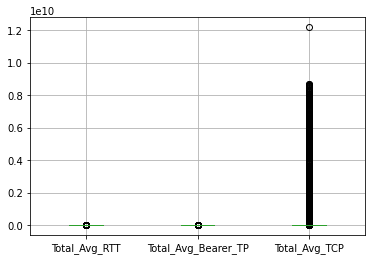

In [46]:
user_experience.boxplot()

<AxesSubplot:>

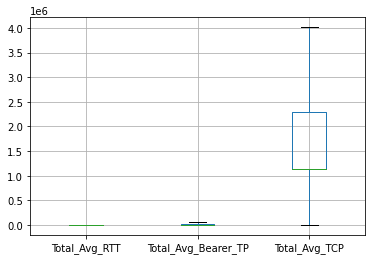

In [47]:
# Remove Outliers

replace_outliers_with_iqr(user_experience, ['Total_Avg_RTT', 'Total_Avg_Bearer_TP', 'Total_Avg_TCP'])
user_experience.boxplot()

#### **Task 3.2.**
Compute & list 10 of the top, bottom and most frequent:
* TCP values in the dataset. 
* RTT values in the dataset.
* Throughput values in the dataset.


#### Sort Dataset by TCP Values 

In [44]:
sorted_by_tcp = user_experience_df.sort_values(
    'Total_Avg_TCP', ascending=False)
top_10 = sorted_by_tcp.head(10)['Total_Avg_TCP']
last_10 = sorted_by_tcp.tail(10)['Total_Avg_TCP']
most_10 = user_experience_df['Total_Avg_TCP'].value_counts().head(10)

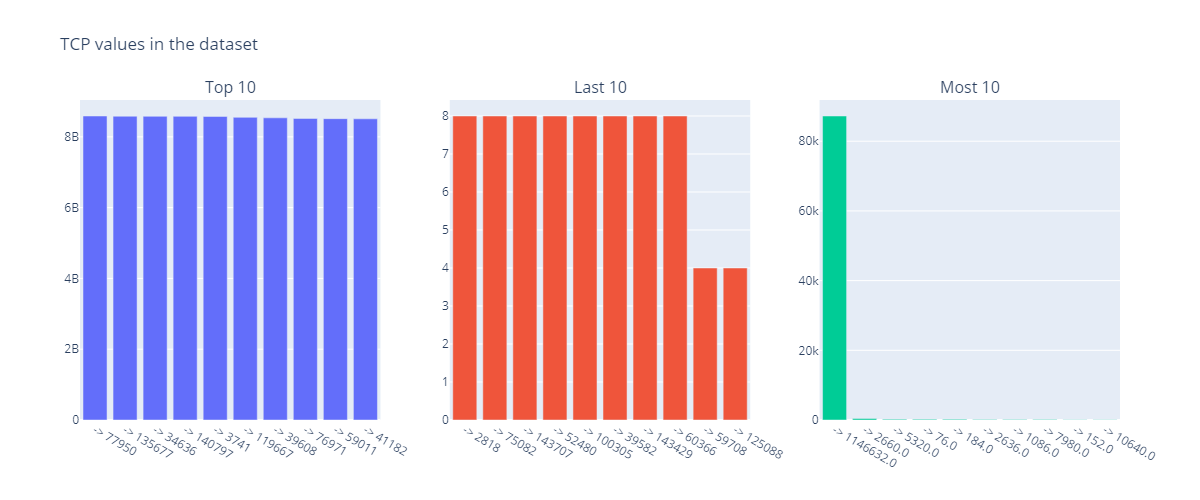

In [45]:
mult_hist([top_10, last_10, most_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])